# Computing ground-truth generalized likelihood
via the integral:

$$ \mathcal{L}(\theta|x_o) = \int{p(x|\theta)e^{-\beta d(x,x_o)}}dx$$

where

- $p(x|\theta)$ is given analytically by the simulator,
- $d(x,x_o)$ is the chosen distance function in data space,
- $\beta$ is a scaling factor over distance (temperature).

or, via Monte Carlo estimate:

$$ \mathbb{E}_{p(x|\theta)} \left[ e^{-\beta d(x,x_o)} \right] $$


# WAIT the loss function with or without the exp?

i.e.:

$$ e^{-\beta \mathbb{E}_{p(x|\theta)} \left[ d(x,x_o) \right]} $$

???

---

to dos:
- make generalized_likelihood handle batch thetas
- write likelihood_fn for the other tasks

In [1]:
import sbibm
import torch
import matplotlib.pyplot as plt

In [2]:
def mse_dist(xs, x_o):
    return torch.mean((xs - x_o)**2, dim=1)

def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, d1_res*d2_res)).T
    return xs

def reference_generalized_likelihood(thetas, x_o, xs, dist_func, log_prob_fn, beta=1.):
    # pad batch dimension
    if thetas.dim()==1:
        thetas = thetas.unsqueeze(0)
    
    # only have to compute this once for the x grid
    tempered_distances = (-beta * dist_func(xs, x_o)).exp()
    
    # loop over all thetas to get generalized likelihood
    integral = torch.stack([(tempered_distances * log_prob_fn(theta, xs).exp()).sum() for theta in thetas])
    return integral

In [3]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)
beta = 1000.

xs = make_2d_grid((-1,1), (-1.5, 1.5), 100,100)
th_res = (100, 100)
thetas = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

# theta = torch.Tensor([1,1])
# generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta=1000.)

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


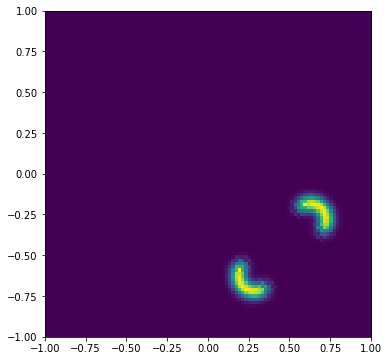

In [4]:
gl = reference_generalized_likelihood(thetas, x_o, xs, mse_dist, log_prob_fn, beta)
gl = torch.reshape(gl, th_res)
plt.figure(figsize=(6,6))
_ = plt.imshow(gl.numpy().T, extent=[-1,1,-1,1], origin='lower')

In [5]:
from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils import BoxUniform

In [10]:
class GBIPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, gen_lh_fn):
        super().__init__(prior, x_o)
        self.gen_lh_fn = gen_lh_fn
        
    def __call__(self, theta, track_gradients = True):
        return self.gen_lh_fn(theta, self.x_o, xs, mse_dist, log_prob_fn, beta).log() + self.prior.log_prob(theta)

In [13]:
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))
gbi_potential = GBIPotential(prior, x_o, reference_generalized_likelihood)
sampler = MCMCPosterior(gbi_potential, prior)
# sampler = RejectionPosterior(gbi_potential, prior)
theta_posterior_samples = sampler.sample((10,))
theta_np = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(-1.0, 1.0)

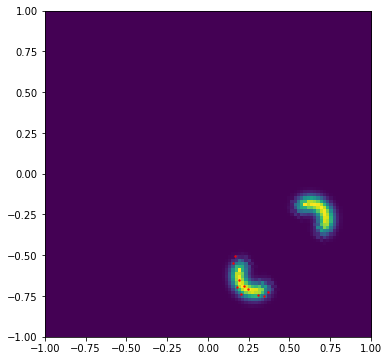

In [14]:
plt.figure(figsize=(6,6))
plt.imshow(gl.numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(theta_np[:,0], theta_np[:,1], 'r.', ms=3, alpha=0.8)
plt.xlim([-1,1]); plt.ylim([-1,1])

---
### Sample-based 

In [15]:
simulator = task.get_simulator()

In [175]:
def reference_generalized_likelihood_sample(thetas, x_o, dist_func, simulator, n_per_theta=100, beta=1.):
    # pad batch dimension
    if thetas.dim()==1:
        thetas = thetas.unsqueeze(0)
    
    # integral_mc = torch.stack([(-beta * dist_func(simulator(theta.repeat((n_per_theta, 1))), x_o)).exp().mean() for theta in thetas]).exp()
    integral_mc = torch.stack([(-beta * dist_func(simulator(theta.repeat((n_per_theta, 1))), x_o).min()).exp() for theta in thetas])
    
    # integral_mc = torch.stack([(-beta * dist_func(simulator(theta.repeat((n_per_theta, 1))), x_o)).exp().mean() for theta in thetas]).exp()
    return integral_mc

In [176]:
gl_mc = reference_generalized_likelihood_sample(thetas, x_o, mse_dist, simulator, n_per_theta=500, beta=1.)
gl_mc = torch.reshape(gl_mc, th_res)

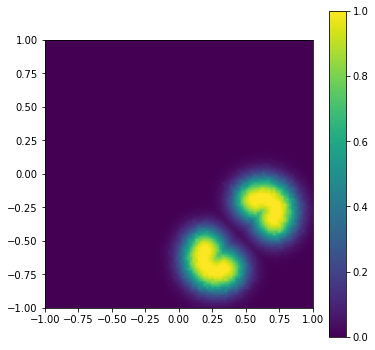

In [180]:

plt.figure(figsize=(6,6))
# _ = plt.imshow(-gl_mc.log().numpy().T, extent=[-1,1,-1,1], origin='lower')
_ = plt.imshow(gl_mc.numpy().T**100, extent=[-1,1,-1,1], origin='lower')
# plt.plot(posterior_samples[:,0], posterior_samples[:,1], 'w.', ms=0.5, alpha=0.1)

plt.colorbar()

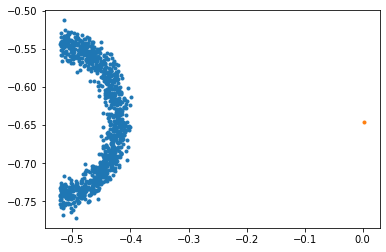

In [111]:
xs = simulator(thetas[-5500].repeat((n_per_theta, 1))).numpy()
plt.plot(xs[:,0], xs[:,1], '.')
plt.plot(x_o[:,0], x_o[:,1], '.')

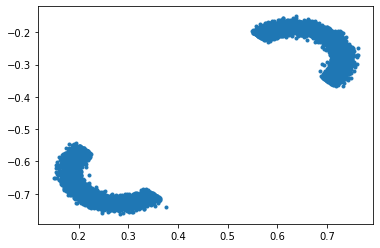

In [92]:
posterior_samples = task.get_reference_posterior_samples(obs_num).numpy()
plt.plot(posterior_samples[:,0], posterior_samples[:,1], '.')

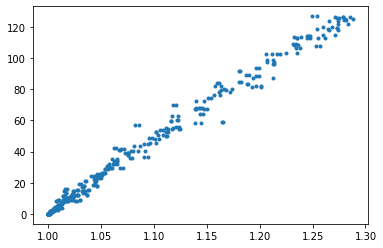

In [78]:
plt.plot(gl_mc.numpy().flatten(), gl.numpy().flatten(), '.')